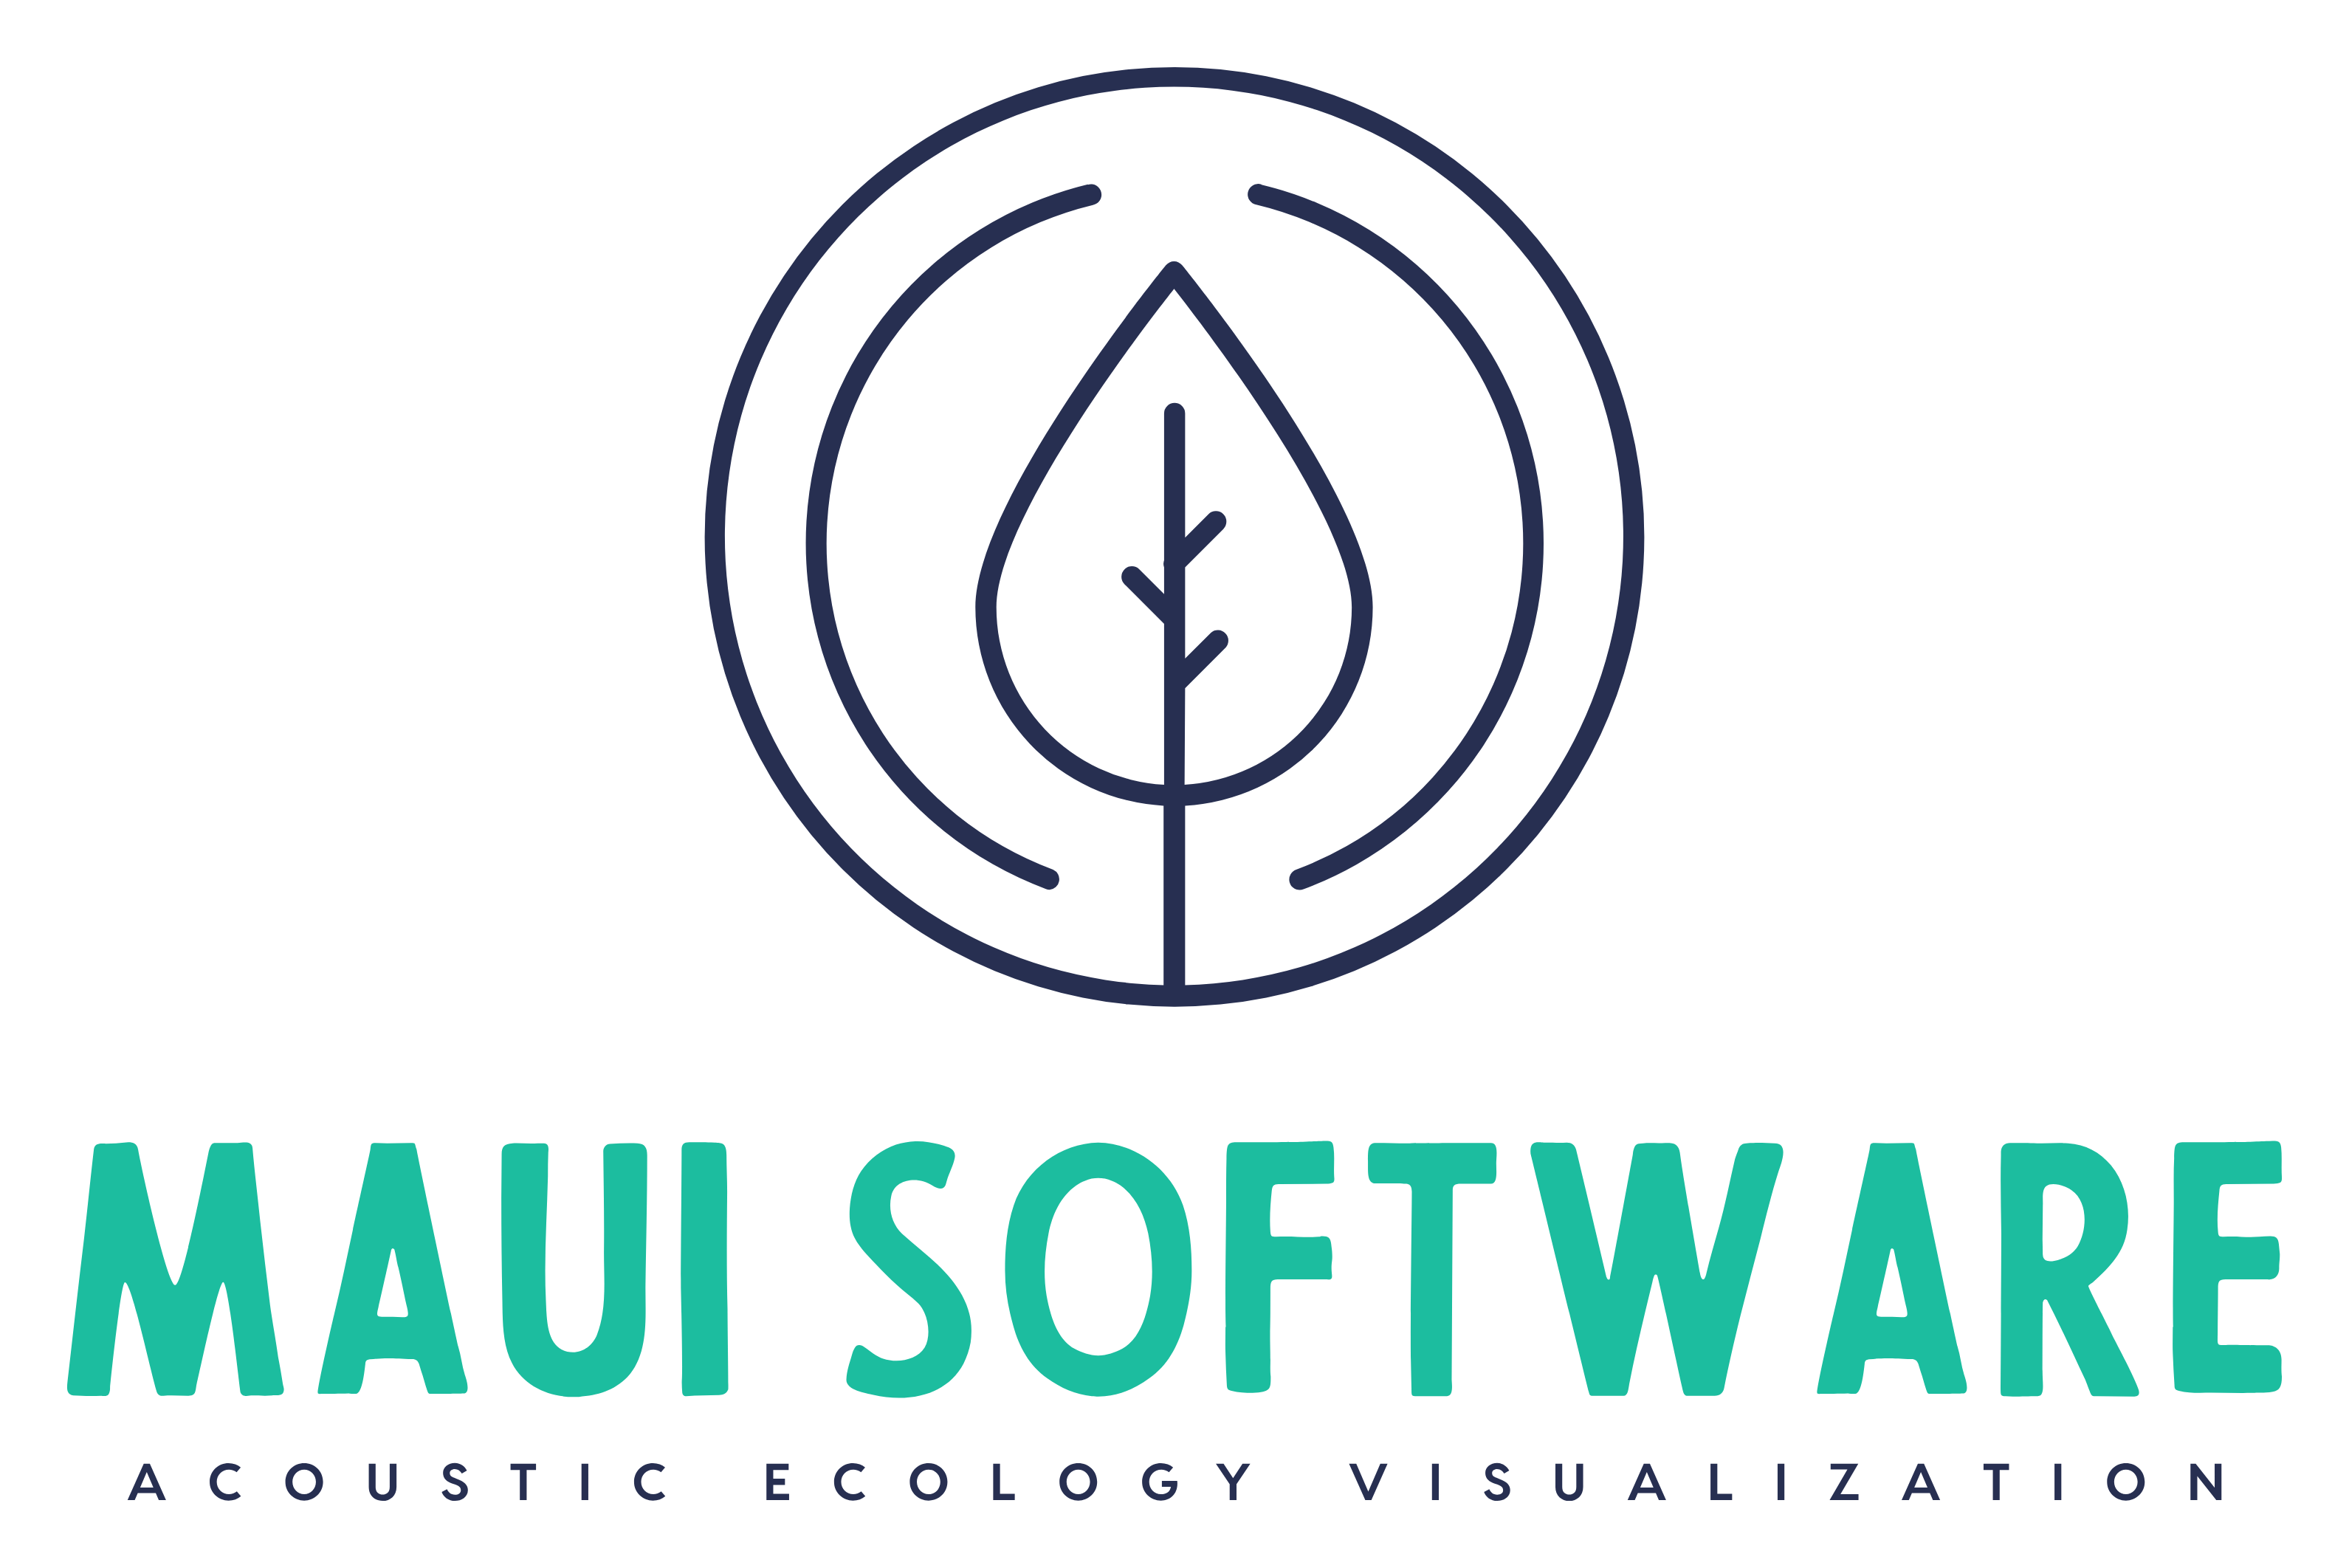

# Welcome to Maui!
## Examples series - Summary Visualizations

In this example, you'll see how ti create visualizations that summarize different aspects of the audios.

If you have any questions or encounter any issues, please let us know through the [project's GitHub discussions](https://github.com/maui-software/maui-software/discussions)!



# 1. Import Maui

## 1.1. Installation

Maui is available on PyPi and can be installed using pip with the following command. Maui has been specifically designed for use in coding interfaces like Colab and Jupyter Lab, leveraging the power of Plotly.



In [1]:
# !pip install maui-software

## 1.2. Import

Once installed, it's time to import!

Maui consists of several submodules that need to be imported individually. For this tutorial, we are particularly interested in utilizing the IO and EDA modules.

In [2]:
!pip install ffmpeg-python
!pip install scikit-maad

In [3]:
import os
import audioread
import ffmpeg
import pandas as pd
from scipy.io import wavfile
from tqdm import tqdm
import audioread

from maad import sound, util, features

from maui import samples, visualizations, acoustic_indices

# 2. Load dataset

The initial task is to load the data. In this example we will use the samples module to extract all audios from Brazil present in Xeno-Canto dataset. Note that Maui counts on an abstraction of Xeno-Canto API, which is simple to use.

The method downloads the data and returns a dataframe with all information necessary to create visualizations over the data, such as path to the audio file, date and time of the recording and other variables present in Xeno-Canto dataset.

In [ ]:
params = {
    'cnt':'brazil'
}

df = samples.get_xc_data(q = params, extract_path="./xc_data")
unhashable_columns = df.columns[df.applymap(lambda x: isinstance(x, (list, dict))).any()]
df = df.drop(columns=unhashable_columns) # removing dictionary columns

df.rename(columns={'local_file_path': 'file_path', 'date': 'dt'}, inplace=True)

In [5]:
# Define a function to calculate audio duration
def get_duration(file_path):
    with audioread.audio_open(file_path) as audio_file:
        return audio_file.duration

# Get the audio duration and add a progress bar to the process
tqdm.pandas(desc="Calculando duração dos áudios")
df['duration'] = df['file_path'].progress_apply(get_duration)


Calculando duração dos áudios: 100%|█████████████████████████████████████████| 500/500 [00:15<00:00, 31.70it/s]


In [ ]:
def convert_mp3_to_wav(df, file_path_col, output_dir):
  if not os.path.exists(output_dir):
      os.makedirs(output_dir)

  successful_conversions = 0
  failed_conversions = 0
  invalid_indices = []  # index of the lines with invalid conversion.

  # Create column to store the new file path of the audio converted to wav
  df['output_file_path'] = None

  for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Converting files"):
      file_path = row[file_path_col]
      if file_path.endswith('.mp3'):
          try:
              # Defines the WAV file path
              base_name = os.path.basename(file_path)
              wav_file_name = os.path.splitext(base_name)[0] + '.wav'
              wav_file_path = os.path.join(output_dir, wav_file_name)

              # Convert MP3 to WAV
              ffmpeg.input(file_path).output(wav_file_path).run(overwrite_output=True)

              # Validate the conversion
              try:
                  wavfile.read(wav_file_path)
                  df.at[index, 'output_file_path'] = wav_file_path
                  successful_conversions += 1
              except Exception:
                  os.remove(wav_file_path)
                  invalid_indices.append(index)
                  failed_conversions += 1
          except Exception:
              invalid_indices.append(index)
              failed_conversions += 1

  # Remove lines with invalid conversion
  df.drop(index=invalid_indices, inplace=True)

  print(f"Successfully converted audios: {successful_conversions}")
  print(f"Unsuccessfully converted audios: {failed_conversions}")

  return df

df = convert_mp3_to_wav(df, 'file_path', 'output_wav_files')


# 3. Acoustic Indices calculation

Acoustic indices will be used for some of the visualizations in this example. Maui does not implements acoustic indices directly, but implementes helper methods that make it easy the process of calculatino acoustic indices for a large dataset. There are three steps to calculate acoustic indices:

1. Define pre calculation methods
2. Define acoustic indices methods
3. Calculate the acoustic indices

We strongly recommend the use of calculation methods already available in the literature. In this example, we will use scikit-maad, a python framework that eficiently implements several acoustic indices.

## 3.1. Pre calculation methods definition
Pre calculation methods are the data preparation step for calculation acoustic indices. it is a function that will be called at the beginning of the calculation, and will create columns on the original dataframe with the aditional data that will be necessary to calculate the desired acoustic indices.

The retun of the function should be a dictionary containning the name of the variable and the value that will be used by acoustic indices methods


In [7]:
def pre_calculation_method(s, fs):

    Sxx_power, tn, fn, ext = sound.spectrogram (s, fs)
    Sxx_noNoise= sound.median_equalizer(Sxx_power, display=False, extent=ext)
    Sxx_dB_noNoise = util.power2dB(Sxx_noNoise)

    Sxx, tn, fn, ext = sound.spectrogram(s, fs, mode='amplitude')

    pre_calc_vars = {'s':s, 'Sxx': Sxx, 'tn':tn , 'fn':fn , 'ext':ext, 'Sxx_dB_noNoise':Sxx_dB_noNoise }
    return pre_calc_vars

## 3.2. Acoustic indices methods definition

To calculate acoustic indices the user will need to define one function to each index that will be calculated. If the index needs some data that was calculated at the pra calculation step, the function that calculates the index should get as parameter **pre_calc_vars**, which is the dictionary returned by the pre calculation method.

Each method should return the value of the index, and they should be stored in a list to use at the next step. In this example, we created a list called **acoustic_indices_methods** with three acoustic indices that will be calculated.

In [8]:
def get_aci(pre_calc_vars):
    aci_xx, aci_per_bin, aci_sum  = features.acoustic_complexity_index(pre_calc_vars['Sxx'])
    indices = {'aci_xx': aci_xx, 'aci_per_bin':aci_per_bin , 'aci_sum':aci_sum}
    return indices

def get_temporal_entropy(pre_calc_vars):
    Ht = features.temporal_entropy(pre_calc_vars['s'])

    indices = {'Ht': Ht}
    return indices


def get_spectral_activity(pre_calc_vars):
    LFC, MFC, HFC = features.spectral_cover(pre_calc_vars['Sxx_dB_noNoise'], pre_calc_vars['fn'])

    indices = {'LFC': LFC, 'MFC':MFC , 'HFC':HFC}
    return indices

acoustic_indices_methods = [get_aci, get_temporal_entropy, get_spectral_activity]

## 3.3. Calculate acoustic indices

This is the moment when the acoustic indices will be calculated. We will use the methods defined at steps 1 and 2. The user can also decide to use paralel or sequential computing. The method require a temporary directory to store preliminar results, which will be accessed in case of failure at some point of the processing. This is necessary because acoustic indices calculation are often high demmand tasks.

In [9]:
temp_dir = os.path.abspath('.//temp_ac_files/')
df_valid = df[df['output_file_path'].notnull()]

df_indices = acoustic_indices.calculate_acoustic_indices(
                    df_init = df_valid,
                    file_path_col = 'output_file_path',
                    acoustic_indices_methods = acoustic_indices_methods,
                    pre_calculation_method = pre_calculation_method,
                    parallel=False,
                    chunk_size = 5,
                    temp_dir = temp_dir
        )


Calculating acoustic indices...
Preparing final dataframe and removing temporary files...
Fixing data types...


In [10]:
df_indices

,id,gen,sp,ssp,group,en,rec,cnt,loc,lat,...,file_downloaded,duration,output_file_path,aci_xx,aci_per_bin,aci_sum,Ht,LFC,MFC,HFC
0,985165,Dendropsophus,microps,NaN,frogs,Nova Friburgo Treefrog,Augusto Matheus dos Santos,Brazil,Sitio Macuquinho Salesópolis São Paulo,-23.5849,...,True,68.6,output_wav_files/XC985165-240907_2152-Dendrops...,1.40752349e-04 9.46602818e-05 1.91598771e-04 ....,"[0.99496305, 0.68195801, 0.61248233, 0.6130832...",352.469317,0.794557,0.225207,0.365322,0.272690
1,983474,Callithrix,jacchus,NaN,land mammals,Common Marmoset,Douglas Meyer,Brazil,Cabo de Santo Agostinho Cabo de Santo Agostin...,-8.2869,...,True,69.4,output_wav_files/XC983474-Callitrichidae_Calli...,1.45342945e-05 1.06827810e-04 1.22023054e-05 ....,"[0.7055035, 0.53551231, 0.58555739, 0.5917504,...",339.867498,0.736435,0.142051,0.244681,0.224252
2,983454,Lycalopex,gymnocercus,NaN,land mammals,Pampas Fox,Douglas Meyer,Brazil,Palmas Palmas Paraná,-26.4789,...,True,22.0,output_wav_files/XC983454-Canidae_Lycalopex_gy...,9.62183135e-05 1.35593301e-04 2.41848633e-04 ....,"[0.7092269, 0.56785476, 0.65193518, 0.68351236...",301.477638,0.869290,0.222274,0.154601,0.130856
3,983453,Lycalopex,gymnocercus,NaN,land mammals,Pampas Fox,Douglas Meyer,Brazil,Bom Jardim da Serra Bom Jardim da Serra Sant...,-28.3404,...,True,26.9,output_wav_files/XC983453-Canidae_Lycalopex_gy...,5.72245778e-05 4.34983609e-05 3.71339036e-04 ....,"[0.67652034, 0.53057403, 0.57844414, 0.6238816...",310.154381,0.706003,0.271686,0.179475,0.126379
4,983367,Tayassu,pecari,NaN,land mammals,White-lipped Peccary,Douglas Meyer,Brazil,Bom Jesus Bom Jesus Rio Grande do Sul,-28.6723,...,True,44.6,output_wav_files/XC983367-Tayassuidae_Tayassu_...,6.68384103e-04 1.10953584e-04 5.42987934e-04 ....,"[0.79479437, 0.44641765, 0.45947433, 0.579043,...",365.914404,0.652068,0.174861,0.193970,0.136549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,68054,Crypturellus,cinereus,NaN,birds,Cinereous Tinamou,Frank Lambert,Brazil,Mato Grosso; Rio Cristalino near Cristalino J...,-9.6000,...,True,59.8,output_wav_files/Crypturellus_cinereus_2004b-F...,7.48377672e-05 2.02529836e-04 7.82737374e-05 ....,"[0.52321003, 0.39362977, 0.51588396, 0.604392,...",301.201713,0.879631,0.149244,0.174763,0.158534
258,47907,Crypturellus,cinereus,NaN,birds,Cinereous Tinamou,Andrew Spencer,Brazil,Cristalino Jungle Lodge MT,-9.5981,...,True,56.4,output_wav_files/Cinereous Tinamou2009-9-15-1.wav,9.66762678e-06 9.74453502e-06 5.09212337e-06 ....,"[0.67950804, 0.68026095, 0.7956228, 0.77600997...",293.353174,0.791968,0.187079,0.191771,0.136632
259,9904,Crypturellus,cinereus,NaN,birds,Cinereous Tinamou,Bradley Davis,Brazil,Cristalino Jungle Lodge MT,-9.5981,...,True,59.8,output_wav_files/BD_2004-04-05_Crypturellus_ci...,3.05615821e-05 9.11703580e-05 1.10721116e-04 ....,"[0.69176967, 0.48793849, 0.56375114, 0.6049545...",301.716382,0.828318,0.160434,0.223564,0.138894
260,789276,Crypturellus,cinereus,NaN,birds,Cinereous Tinamou,Ina Tirri,Brazil,Canutama Amazonas,-8.3127,...,True,112.2,output_wav_files/XC789276-220324_0203_Cinereou...,3.83368843e-05 1.78541250e-06 5.78713811e-05 ....,"[0.801189, 0.57159215, 0.6079107, 0.62368973, ...",317.560993,0.974143,0.195624,0.199385,0.235056


# 4. Visualizations

Now that we have all the necessary data, it is time to create some visualizations!

In this example notebook, the goal is to create visualizations that summarize the data. To achieve this goal, we will create and discuss the following visualizations:

1.asd
2.asd
3.asd

## 4.1. Radar plot




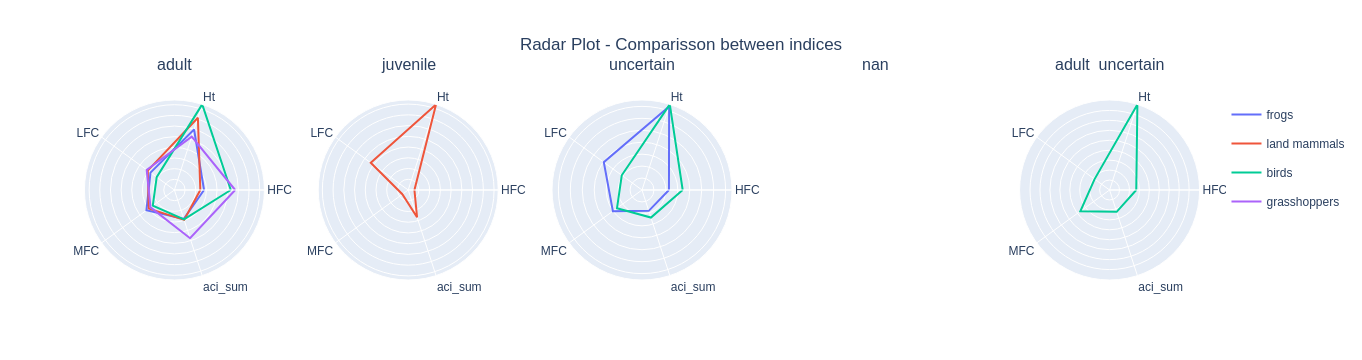

In [16]:
df_valid = df_indices.dropna(subset=['group'])
fig = visualizations.indices_radar_plot(df_valid, indices=['aci_sum', 'Ht', 'LFC', 'MFC', 'HFC'], agg_type='mean', group_by=['stage', 'group'], max_cols=5)

## 4.2. Histogram plot

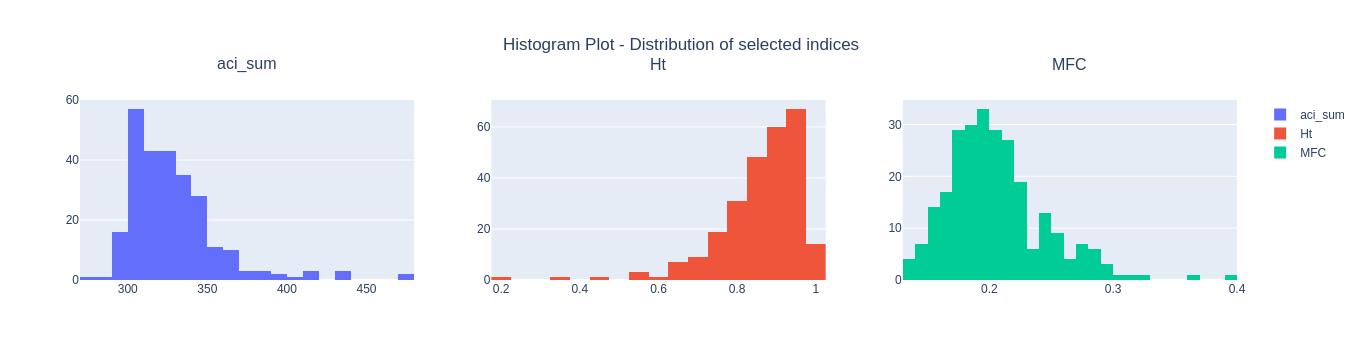

In [17]:
fig = visualizations.indices_histogram_plot(df_indices, indices=['aci_sum', 'Ht', 'MFC'], group_by=None, max_cols=3)

## 4.3. Violin plot

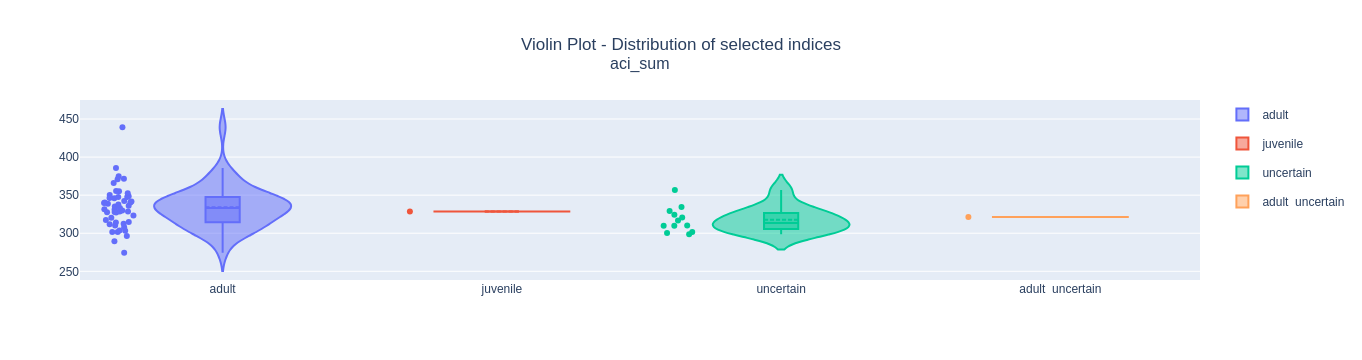

In [18]:
fig = visualizations.indices_violin_plot(df_indices, indices=['aci_sum'], group_by='stage')